In [30]:
#
# Content Summary Model - Seq2Seq with Attention
#

In [31]:
# TODO
# - implement the evaluation metrics
# - implement beam search in generator
# - compare GRU and BI-GRU in performance
# - compare LSTM and GRU in performance
# - use CNN as compressor
# - try pretrain compressor and generator on language model
# - use a concatenated vocab encoder/decoder for compressor and generator

In [32]:
#
# Hyperparam
#
PROJECT_PATH = "."

DATASET_SIZE = 2500
BATCH_SIZE = 40
FILTERED_DATASET_SIZE = DATASET_SIZE
BATCHES_PER_EPOCH = FILTERED_DATASET_SIZE // BATCH_SIZE

MAX_CONTENT_LENGTH = 4000
CONTENT_SEGMENT_LENGTH = 100
CONTENT_NUM_SEGMENT = MAX_CONTENT_LENGTH // CONTENT_SEGMENT_LENGTH

MAX_SUMMARY_LENGTH = 151
SUMMARY_MINI_BATCH_LENGTH = 3
SUMMARY_NUM_MINI_BATCH = (MAX_SUMMARY_LENGTH - 1) // SUMMARY_MINI_BATCH_LENGTH

EMBEDDING_SIZE = 50
RNN_SIZE = 128

EPOCHS = 10

In [33]:
import time
import numpy as np
import tensorflow as tf

from tqdm import tqdm
from pprint import pprint

from lib.data import load_TED_dataset
from lib.text import (
    build_encoder_decoder_from_vocab,
    flat_clip_in_words,
)

In [34]:
# TabNine::sem

In [35]:
#
# Load and Preprocess Dataset
#
content_text, summary_text = load_TED_dataset(
    include_summary=True, project_path=PROJECT_PATH
)

flattened_content = [
    flat_clip_in_words(clip) for clip in tqdm(content_text[:DATASET_SIZE])
]
# filter out the prefix(TED subtitles and translation...) in summary
flattened_summary = [
    flat_clip_in_words(clip[35:]) for clip in tqdm(summary_text[:DATASET_SIZE])
]

flattened_content_summary = list(zip(flattened_content, flattened_summary))

print(content_text[91])
print(summary_text[91])
print(flattened_content_summary[91])

ted_en-20160408.zip already downloaded.



100%|██████████| 2085/2085 [00:03<00:00, 550.76it/s]

100%|██████████| 2085/2085 [00:00<00:00, 17139.71it/s]

Jenni Chang: When I told my parents I was gay, the first thing they said to me was, "We're bringing you back to Taiwan."
(Laughter)
In their minds, my sexual orientation was America's fault. The West had corrupted me with divergent ideas, and if only my parents had never left Taiwan, this would not have happened to their only daughter. In truth, I wondered if they were right.
Of course, there are gay people in Asia, just as there are gay people in every part of the world. But is the idea of living an "out" life, in the "I'm gay, this is my spouse, and we're proud of our lives together" kind of way just a Western idea?
If I had grown up in Taiwan, or any place outside of the West, would I have found models of happy, thriving LGBT people?
Lisa Dazols: I had similar notions. As an HIV social worker in San Francisco, I had met many gay immigrants. They told me their stories of persecution in their home countries, just for being gay, and the reasons why they escaped to the US. I saw how thi

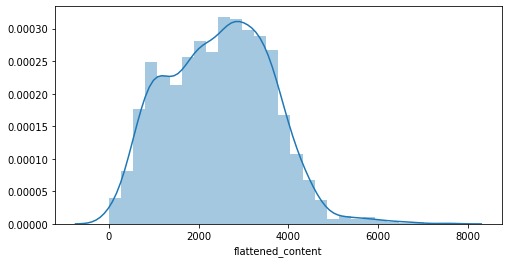

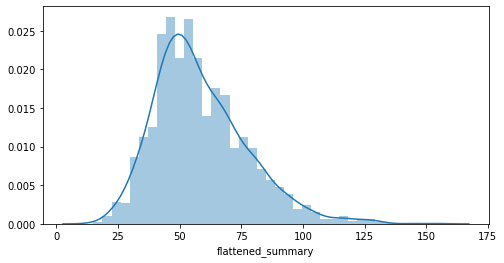

In [36]:
#
# Inspect Dataset
#
# 1) check if there's extreme outliners (content with no length)
# 2) check the length distribution to choose a length cap to make padding efficient

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.distplot([len(clip) for clip in flattened_content], axlabel="flattened_content")

plt.figure(figsize=(8, 4))
sns.distplot([len(clip) for clip in flattened_summary], axlabel="flattened_summary")

In [37]:
#
# Filter Dataset
#
# This intends to improve dataset quality and training efficiency
# 1) remove short content (input sequence) so that input has sufficient information
# 2) cap the max length of content to reduce the amount of padding needed to match input
# 3) remove short summary (output sequence) so that output has sufficient quality

filtered_flattened_content_summary = list(
    filter(
        lambda pair: len(pair[0]) in range(200, MAX_CONTENT_LENGTH + 1)
        and len(pair[1]) in range(25, MAX_SUMMARY_LENGTH + 1),
        flattened_content_summary,
    )
)

FILTERED_DATASET_SIZE = len(filtered_flattened_content_summary)
BATCHES_PER_EPOCH = FILTERED_DATASET_SIZE // BATCH_SIZE

print(FILTERED_DATASET_SIZE)
print(BATCHES_PER_EPOCH)

filtered_flattened_content = [
    content for (content, summary) in filtered_flattened_content_summary
]
filtered_flattened_summary = [
    summary for (content, summary) in filtered_flattened_content_summary
]

1883
47


In [38]:
#
# word level encoding
#

In [39]:
#
# Build Encoder, Decoder
#
content_vocab = set([word for clip in filtered_flattened_content for word in clip])
summary_vocab = set([word for clip in filtered_flattened_summary for word in clip])

content_encoder, content_decoder = build_encoder_decoder_from_vocab(content_vocab)
summary_encoder, summary_decoder = build_encoder_decoder_from_vocab(summary_vocab)

print(len(content_encoder))
print(len(content_decoder))
print(len(summary_encoder))
print(len(summary_decoder))

51048
51048
12868
12868


In [40]:
#
# Encode dataset
#
# Here custom encoder and padding are used as they allow more controls
def encode_clips(clips, encoder):
    return [[encoder[word] for word in clip] for clip in tqdm(clips)]


def pad_clips(encoded_clips, set_length=0):
    longest_clip_length = max([len([word for word in clip]) for clip in encoded_clips])
    padded_length = set_length if set_length > 0 else longest_clip_length

    return [
        np.append(encoded_clip, np.zeros(padded_length - len(encoded_clip), dtype=int))
        for encoded_clip in tqdm(encoded_clips)
    ]


encoded_content = pad_clips(
    encode_clips(filtered_flattened_content, content_encoder),
    set_length=MAX_CONTENT_LENGTH,
)

encoded_summary = pad_clips(
    encode_clips(filtered_flattened_summary, summary_encoder),
    set_length=MAX_SUMMARY_LENGTH,
)

dataset = (
    tf.data.Dataset.from_tensor_slices((encoded_content, encoded_summary))
    .shuffle(DATASET_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
)

example_content, example_summary = next(iter(dataset))
print(example_content.shape, example_summary.shape)


100%|██████████| 1883/1883 [00:00<00:00, 4129.19it/s]

100%|██████████| 1883/1883 [00:00<00:00, 4888.06it/s]

100%|██████████| 1883/1883 [00:00<00:00, 125856.52it/s]

100%|██████████| 1883/1883 [00:00<00:00, 36390.37it/s]


(40, 4000) (40, 151)


In [41]:
#
# Model - input sequence compressor
#
class SourceCompressor(tf.keras.Model):
    def __init__(self, source_encoder_size, embedding_size, rnn_units):
        super(SourceCompressor, self).__init__()

        self.rnn_units = rnn_units

        self.embedding_layer = tf.keras.layers.Embedding(
            source_encoder_size, embedding_size
        )
        self.gru_layer = tf.keras.layers.GRU(
            rnn_units, return_sequences=True, return_state=True,
        )

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.rnn_units))

    def call(self, input_x, initial_state):
        input_x_embedding = self.embedding_layer(input_x)
        state_history, final_state = self.gru_layer(
            input_x_embedding, initial_state=initial_state
        )
        return state_history, final_state

In [42]:
def segmented_source_compressor(
    source_input,
    source_compressor,
    segment_length=CONTENT_SEGMENT_LENGTH,
    reverse=False,
    stateful=True,
    show_progress=False,
):
    """
    @input: source_input = tf.Tensor[batch_size, clip_length]
    
    @internal: segment_histories = tf.TensorArray[num_segment, batch_size, segment_length, hidden_size]
    @internal: segment_compressed = tf.TensorArray[num_segment, batch_size, hidden_size]
    
    @output: segment_histories = tf.Tensor[batch_size, num_segment, segment_length, hidden_size]
    @output: segment_compressed = tf.Tensor[batch_size, num_segment, hidden_size]
    """
    (batch_size, clip_length) = source_input.shape
    num_segment = clip_length // segment_length

    segment_histories = tf.TensorArray(tf.float32, size=num_segment)
    segment_states = tf.TensorArray(tf.float32, size=num_segment)

    compressor_state = source_compressor.init_state(batch_size)

    source_input_for_segment = (
        tf.reverse(source_input, axis=[1]) if reverse else source_input
    )

    for i in tqdm(tf.range(num_segment)) if show_progress else tf.range(num_segment):

        segment = source_input_for_segment[
            :, i * segment_length : (i + 1) * segment_length
        ]

        (history, state) = source_compressor(segment, compressor_state)

        segment_histories = segment_histories.write(i, history)
        segment_states = segment_states.write(i, state)

        if stateful:
            # pass over state between segments for truncated BPTT
            compressor_state = state

    return (
        tf.transpose(segment_histories.stack(), [1, 0, 2, 3]),
        tf.transpose(segment_states.stack(), [1, 0, 2]),
    )

In [43]:
content_compressor = SourceCompressor(len(content_encoder), EMBEDDING_SIZE, RNN_SIZE)

In [44]:
(sample_source, sample_target) = next(iter(dataset))

print(sample_source.shape)

(40, 4000)


In [45]:
start = time.time()

(
    sample_source_segment_histories,
    sample_source_segment_states,
) = segmented_source_compressor(
    sample_source, content_compressor, show_progress=True, reverse=True
)

print(time.time() - start)

print((sample_source_segment_histories).shape)
print((sample_source_segment_states).shape)


100%|██████████| 40/40 [00:00<00:00, 173.58it/s]

0.23648858070373535
(40, 40, 100, 128)
(40, 40, 128)


In [46]:
#
# Model - Attnetion Mechanism
#


class Attention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Attention, self).__init__()

        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def process_history(self, history):
        """
        @input: histories = tf.Tensor(batch_size, sequence_length, hidden_size)
        @weights: W2 = (hidden_size, attention_units)
        @internal: self.history_in_attention = (batch_size, sequence_length, attention_units
        """
        self.history = history
        self.history_in_attention = self.W2(history)

    def call(self, query_state, return_vector=True):
        """
        @input: query_state = tf.Tensor(batch_size, hidden_size)
        
        @weights: W1 = (hidden_size, attention_units)
        @weights: V = (attention_units, 1)
        
        @internal: query_state_in_attention = tf.Tensor(batch_size, 1, attention_units)
        @internal: self.history_in_attention = tf.Tensor(batch_size, sequence_length, attention_units)
        @internal: attention_state = (batch_size, sequence_length, attention_units)
        @internal: attention_score = (batch_size, sequence_length, 1)
        @internal: context_state = (batch_size, sequence_length, hidden_size)
        
        @output: attention_weights = (batch_size, sequence_length, 1)
        @output: attention_vector = (batch_size, hidden_size)
        """
        # this is to match the query_state.shape with histories.shape
        query_state_in_attention = self.W1(tf.expand_dims(query_state, 1))

        # model interactions of attentions between query state and histories as addition
        # normalise to (-1,1) with tanh
        # [1, attention_units] is broadcasted to [sequence_length, attention_units]
        # after addition: [sequence_length, attention_units]
        attention_state = tf.nn.tanh(
            query_state_in_attention + self.history_in_attention
        )
        attention_score = self.V(attention_state)
        attention_weights = tf.nn.softmax(attention_score, axis=1)

        if return_vector:
            context_state = attention_weights * self.history
            attention_vector = tf.reduce_sum(context_state, axis=1)
            return attention_weights, attention_vector

        return attention_weights

In [47]:
# 2D/Nested Attention

# Given that query_state from the generator will be of shape (batch_size, hidden_size), the 2DAttention
# layer is learning the interaction between query_state and histories in 2D shape.

# One way to do it is to broadcast the query state over both dimensions (batch_size, 1, 1, hidden_size)
# and adding it to all states in the history after weights, then reshaped to (batch_size, 1x1, hidden_size)
# to be output to V to produce attention_score; This way the attention is equivelant to reshape the history
# to 1D while utilised the truncated BPTT in the compressor to avoid vanishing gradient.

# The first way doesn't utilise the relationship present between states in the history. By firstly 
# learning the interactions between the sampled states (segment end) and its segmeng histories as
# a set of attention_weights(segment_weights). And we can compress the histories further down to 
# (batch_size, num_segment) attention vectors(segment_attention_vectors).
# Then by learning the interaction between query state and sample states as another set of attention
# weights(state_weights). We can then construct the final attention_vector by 
#    sum(state_weights * segment_attention_vectors )
#    equivalent to sum(segment_weights * state_weights * histories)
# While the (sample state ~ segment history) interactions remain unchange in one set of history, this
# nested attention structure can potentially be computationally more efficient.
# Here we need to use 2 sets of weights as they are learning the interactions of different sets of
# variables.

In [48]:
#
# Model - nested attention
#


class NestedAttention(tf.keras.Model):
    def __init__(self, attention_units):
        """
        @input: attention_units = attention_size: size of the attention matrix
        """
        super(NestedAttention, self).__init__()

        self.state_to_segment_attention = Attention(attention_units)
        self.state_to_states_attention = Attention(attention_units)

    def process_history_attention(self, segment_states, segment_histories):
        """
        @input: segment_states = tf.Tensor(batch_size, num_segment, hidden_size)
        @input: segment_histories = tf.Tensor(batch_size, num_segment, segment_length, hidden_size)

        @internal: state_to_segment_attention_weights = tf.TensorArray[num_segment, batch_size, segment_length, 1]

        @output: state_to_segment_attention_weights = tf.Tensor[batch_size, num_segment, segment_length, 1]
        @output*: state_to_segment_attention_vectors = tf.Tensor(batch_size, num_segment, hidden_size)
        """

        (batch_size, num_segment, _) = segment_states.shape

        state_to_segment_attention_weights = tf.TensorArray(
            tf.float32, size=num_segment
        )
        state_to_segment_attention_vectors = tf.TensorArray(
            tf.float32, size=num_segment
        )

        for i in tf.range(num_segment):
            self.state_to_segment_attention.process_history(segment_histories[:, i])
            attention_weights, attention_vector = self.state_to_segment_attention(
                segment_states[:, i]
            )
            state_to_segment_attention_weights = state_to_segment_attention_weights.write(
                i, attention_weights
            )
            state_to_segment_attention_vectors = state_to_segment_attention_vectors.write(
                i, attention_vector
            )

        self.state_to_segment_attention_weights = tf.transpose(
            state_to_segment_attention_weights.stack(), [1, 0, 2, 3]
        )
        self.state_to_segment_attention_vectors = tf.transpose(
            state_to_segment_attention_vectors.stack(), [1, 0, 2]
        )

        self.state_to_states_attention.process_history(segment_states)

        self.state_history = segment_states
        self.segment_histories = segment_histories

    def call(self, query_state):
        """
        @input:query_state = tf.Tensor(batch_size, hidden_size)
        
        @internal: state_history = (batch_size, num_segment, attention_units)
        
        @internal: state_to_states_attention_weights = (batch_size, num_segment, 1)
        @internal: self.state_to_segment_attention_weights = (batch_size, num_segment, sequence_length, 1)
        
        @output: combined_attention_weights = (batch_size, num_segment, segment_length, 1)
        @internal: self.segment_histories = (batch_size, num_segment, segment_length, hidden_size)
        
        @internal: context_state = (batch_size, num_segment, segment_length, hidden_size)
        
        @output: combined_attention_vectors = (batch_size, hidden_size)
        """
        state_to_states_attention_weights = self.state_to_states_attention(
            query_state, return_vector=False
        )

        # broadcast state_attention_weights to shape
        # [batch_size, num_segment, 1(segment_length), 1]
        # to mach self.state_to_segment_attention_weights
        # [batch_size, num_segment, segment_length, 1]
        # this applies segment_weight to weights across segment_length
        # otherwise multiply would be
        # [batch_size, num_segment, 1] * [num_segment, segment_length, 1]
        # for each batch in self.state_to_segment_attention_weights
        combined_attention_weights = tf.math.multiply(
            tf.expand_dims(state_to_states_attention_weights, axis=-1),
            self.state_to_segment_attention_weights,
        )
        context_state = tf.math.multiply(
            state_to_states_attention_weights, self.state_to_segment_attention_vectors
        )
        combined_attention_vectors = tf.reduce_sum(context_state, 1)

        return combined_attention_weights, combined_attention_vectors

In [49]:
nested_attention = NestedAttention(RNN_SIZE)

In [50]:
start = time.time()
query_state = sample_source_segment_states[:, -1]
nested_attention.process_history_attention(
    sample_source_segment_states, sample_source_segment_histories
)

for n in range(100):
    (attention_weights, context_vector) = nested_attention(query_state)

print(time.time() - start)
print(attention_weights.shape)
print(context_vector.shape)

0.3996577262878418
(40, 40, 100, 1)
(40, 128)


In [51]:
#
# Model - output sequence generator
#


class TargetGenerator(tf.keras.Model):
    def __init__(self, target_decoder_size, embedding_size, rnn_units):
        super(TargetGenerator, self).__init__()

        self.rnn_units = rnn_units

        self.embedding_layer = tf.keras.layers.Embedding(
            target_decoder_size, embedding_size
        )
        self.gru_layer = tf.keras.layers.GRU(rnn_units, return_state=True)
        self.output_layer = tf.keras.layers.Dense(target_decoder_size)

    def call(self, input_x, context_vector, input_state=None):
        """
        @input: input_x = tf.Tensor(batch_size, sequence_length, 1)
        @input: context_vector = tf.Tensor(batch_size, hidden_size)
        
        @internal: input_x_embedding = tf.Tensor(batch_size, sequence_length, embedding_size)
        @internal: input_x_embedding_with_context = tf.Tensor(batch_size, sequence_length, embedding_size + hidden_size
        
        @output: output = (batch_size, sequence_length, embedding_size)
        @output: state = (batch_size, hidden_size)
        """
        input_x_embedding = self.embedding_layer(input_x)
        # match context_vector shape to (batch_size, sequence_length(1), hidden_size)
        input_x_embedding_with_context = tf.concat(
            [tf.expand_dims(context_vector, 1), input_x_embedding], axis=-1
        )
        _, state = self.gru_layer(
            input_x_embedding_with_context, initial_state=input_state
        )

        output = self.output_layer(state)

        return output, state

In [52]:
summary_generator = TargetGenerator(len(summary_decoder), EMBEDDING_SIZE, RNN_SIZE)

In [53]:
generator_input = tf.convert_to_tensor([[summary_encoder["_BOC_"]]] * BATCH_SIZE)
input_state = sample_source_segment_states[:, -1]


start = time.time()
sample_output = []
for _ in tqdm(tf.range(40)):
    (attention_weights, context_vector) = nested_attention(input_state)
    generated_output, generator_state = summary_generator(
        generator_input, context_vector, input_state
    )
    input_state = generator_state


print(time.time() - start)
print(generated_output.shape)
print(generator_state.shape)


100%|██████████| 40/40 [00:00<00:00, 172.26it/s]

0.23523211479187012
(40, 12868)
(40, 128)


In [54]:
#
# Loss Function
#

optimizer = tf.keras.optimizers.Adam()
loss_method = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction="none"
)

def loss_function(real, pred):
    # mask = [False, False, False, True, False, ...] (one-hot vector)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_method(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss_masked = loss * mask
    
    return tf.reduce_mean(loss_masked)

In [55]:
#
# training function
#
@tf.function
def train_batch(
    source_sequence, target_sequence, compressor, generator, nested_attention,
):
    batch_loss = 0.0

    with tf.GradientTape() as tape:

        (
            source_segment_histories,
            source_segment_states,
        ) = segmented_source_compressor(
            source_sequence, content_compressor, reverse=True
        )

        nested_attention.process_history_attention(
            source_segment_states, source_segment_histories
        )

        last_state = source_segment_states[:, -1]

        for i in tf.range(SUMMARY_NUM_MINI_BATCH):
            mini_batch_loss = 0.0
            # update generator to generate sequence output would 
            # require truncated sequence input (not depend on each other) 
            # and concatenating the corresponding context vector
            # which is equivalent to increase batch_size while input only one in sequence
            for j in tf.range(SUMMARY_MINI_BATCH_LENGTH):
                # using teacher forcing during training
                t = i * SUMMARY_MINI_BATCH_LENGTH + j
                input_t = target_sequence[:, t]
                generator_input = tf.expand_dims(input_t, 1)

                (_, context_vector) = nested_attention(last_state)
                # passing over last_state as input_state to GRU helps reducing the loss
                # in the use case of dynamic unrolling
                predictions, last_state = generator(
                    generator_input, context_vector, last_state
                )
                target_t = target_sequence[:, t + 1]
                # accumulate loss from each step
                loss = loss_function(target_t, predictions)

                mini_batch_loss += loss
                batch_loss += loss

            mini_batch_loss_per_step = mini_batch_loss / int(SUMMARY_MINI_BATCH_LENGTH)
            # concat all the trainable variables
            variables = (
                compressor.trainable_variables
                + generator.trainable_variables
                + nested_attention.trainable_variables
            )
            gradients = tape.gradient(mini_batch_loss_per_step, variables)
            optimizer.apply_gradients(zip(gradients, variables))

    batch_loss_per_step = batch_loss / int(
        SUMMARY_NUM_MINI_BATCH * SUMMARY_MINI_BATCH_LENGTH
    )

    return batch_loss_per_step

In [56]:
import os

MODEL_NAME = "content_summary"
checkpoint_dir = f"{PROJECT_PATH}/output/training_checkpoints/{MODEL_NAME}"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    optimizer=optimizer,
    content_compressor=content_compressor,
    summary_generator=summary_generator,
    nested_attention=nested_attention,
)

In [57]:
def train_model(
    dataset, compressor, generator, nested_attention, epochs=EPOCHS,
):
    for epoch in range(EPOCHS):
        start = time.time()
        progress = tqdm(total=BATCHES_PER_EPOCH)

        epoch_loss = 0

        for (n, (source, target)) in enumerate(dataset.take(BATCHES_PER_EPOCH)):
            batch_loss = train_batch(
                source, target, compressor, generator, nested_attention,
            )
            epoch_loss += batch_loss
            
            progress.update(1)

        progress.close()
        checkpoint.save(file_prefix=checkpoint_prefix)
        print(f"Epoch {epoch + 1} Loss: {epoch_loss/BATCHES_PER_EPOCH:.4f}")
        print(f"Time taken: { time.time() - start }s\n")

In [60]:
train_model(dataset, content_compressor, summary_generator, nested_attention)


100%|██████████| 47/47 [54:33<00:00, 69.65s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 1 Loss: 2.1252
Time taken: 3273.739562511444s




100%|██████████| 47/47 [54:41<00:00, 69.82s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 2 Loss: 1.9757
Time taken: 3281.8179607391357s




100%|██████████| 47/47 [54:11<00:00, 69.17s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 3 Loss: 1.8433
Time taken: 3251.2802391052246s




100%|██████████| 47/47 [54:05<00:00, 69.06s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 4 Loss: 1.7161
Time taken: 3245.714179992676s




100%|██████████| 47/47 [54:14<00:00, 69.25s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 5 Loss: 1.5944
Time taken: 3255.0351028442383s




100%|██████████| 47/47 [54:27<00:00, 69.53s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 6 Loss: 1.4808
Time taken: 3267.8934066295624s




100%|██████████| 47/47 [54:18<00:00, 69.32s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 7 Loss: 1.3795
Time taken: 3258.174809217453s




100%|██████████| 47/47 [54:01<00:00, 68.97s/it]

  0%|          | 0/47 [00:00<?, ?it/s]

Epoch 8 Loss: 1.2828
Time taken: 3241.7171471118927s




 15%|█▍        | 7/47 [08:00<45:46, 68.66s/it]

KeyboardInterrupt: 

In [59]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [61]:
def output_logits_to_sample(output_logits):
    output_sample_tensor = tf.random.categorical(output_logits, num_samples=1)
    output_sample = tf.squeeze(output_sample_tensor, axis=-1).numpy()
    return output_sample

In [62]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

def plot_attention(attention_weights_histories, source, predicted):
    plt.figure(figsize = (10,7))
    sns.heatmap(attention_weights_histories)

In [63]:
def evaluate(
    source_sequence,
    compressor,
    generator,
    nested_attention,
    generator_sequence_length=MAX_SUMMARY_LENGTH,
    generator_seed=summary_encoder["_BOC_"],
    generator_stopper=summary_encoder["_EOC_"],
    reverse_compression=False,
    greedy_search=True,
):
    num_segment = len(source_sequence) // CONTENT_SEGMENT_LENGTH

    attention_weights_histories = np.zeros(
        (generator_sequence_length, num_segment * CONTENT_SEGMENT_LENGTH)
    )
    output = []

    source_segment_histories, source_segment_states = segmented_source_compressor(
        tf.convert_to_tensor([source_sequence]), compressor, reverse=reverse_compression
    )

    nested_attention.process_history_attention(
        source_segment_states, source_segment_histories
    )

    last_state = source_segment_states[:, -1]
    generator_input = tf.expand_dims([generator_seed], 1)

    for t in tqdm(tf.range(generator_sequence_length)):
        (attention_weights, context_vector) = nested_attention(last_state)
        predictions, last_state = generator(generator_input, context_vector, last_state)

        # flatten the weights
        attention_weights = tf.reshape(attention_weights, (-1,))
        attention_weights_histories[t] = (
            np.flip(attention_weights.numpy())
            if reverse_compression
            else attention_weights.numpy()
        )

        predicted_target_token_id = (
            tf.argmax(predictions[0]).numpy()
            if greedy_search
            else output_logits_to_sample(predictions)[0]
        )
        output.append(predicted_target_token_id)

        if predicted_target_token_id == generator_stopper:
            return output, attention_weights_histories

        generator_input = tf.expand_dims([predicted_target_token_id], 1)

    return output, attention_weights_histories

In [64]:
def summarise(
    content_sequence,
    compressor,
    generator,
    nested_attention,
    reverse_compression=False,
    greedy_search=True,
):
    predicted_summary_sequence, attention_weights_histories = evaluate(
        content_sequence,
        compressor,
        generator,
        nested_attention,
        reverse_compression=reverse_compression,
        greedy_search=greedy_search,
    )

    content = [content_decoder[token] for token in content_sequence.numpy()]
    predicted_summary = [summary_decoder[token] for token in predicted_summary_sequence]

    print(f'Input: {" ".join(content)}')
    print(f'Predicted summary: {" ".join(predicted_summary)}')

    plot_attention(attention_weights_histories, content, predicted_summary)

In [65]:
print(" ".join([summary_decoder[token] for token in sample_target[3].numpy()]))

_BOC_  caroline phillips cranks out tunes on a seldom heard folk instrument the hurdy gurdy a .  .  .  the wheel fiddle .  a searching basque melody follows her fun lesson on its unique anatomy and 1 000 year history .  . _EOC_ * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * *




  0%|          | 0/151 [00:00<?, ?it/s]

 15%|█▌        | 23/151 [00:00<00:00, 167.76it/s]


Input: _BOC_  now since this is tedglobal who can tell me what this is called in french .  i see you re all up on the history of hurdy gurdy vielle roue .  and in spanish zanfona .  and in italian ghironda okay .  hurdy gurdy or wheel fiddle .  .  so these are the different kinds and shapes of the hurdy gurdy .  the hurdy gurdy is the only musical instrument that uses a crank to turn a wheel to rub strings like the bow of a violin to produce music .  it has three different kinds of strings .  the first string is the drone string which plays a continuous sound like the bagpipe .  the second string is a melody string which is played with a wooden keyboard tuned like a piano .  and the third string is pretty innovative .  it s also the only instrument that uses this kind of technique .  it activates what s called the buzzing bridge or the dog .  when i turn the crank and i apply pressure it makes a sound like a barking dog .  so all of this is pretty innovative if you consider that the hu

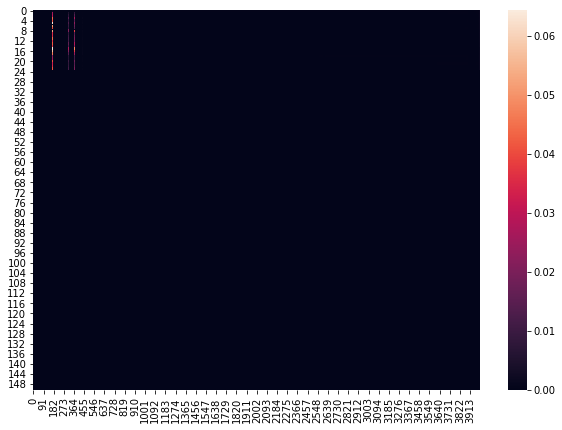

In [66]:
summarise(
    sample_source[3],
    content_compressor,
    summary_generator,
    nested_attention,
    reverse_compression=True,
    greedy_search=False
)



  0%|          | 0/151 [00:00<?, ?it/s]

 14%|█▍        | 21/151 [00:00<00:00, 155.19it/s]


Input: _BOC_  now since this is tedglobal who can tell me what this is called in french .  i see you re all up on the history of hurdy gurdy vielle roue .  and in spanish zanfona .  and in italian ghironda okay .  hurdy gurdy or wheel fiddle .  .  so these are the different kinds and shapes of the hurdy gurdy .  the hurdy gurdy is the only musical instrument that uses a crank to turn a wheel to rub strings like the bow of a violin to produce music .  it has three different kinds of strings .  the first string is the drone string which plays a continuous sound like the bagpipe .  the second string is a melody string which is played with a wooden keyboard tuned like a piano .  and the third string is pretty innovative .  it s also the only instrument that uses this kind of technique .  it activates what s called the buzzing bridge or the dog .  when i turn the crank and i apply pressure it makes a sound like a barking dog .  so all of this is pretty innovative if you consider that the hu

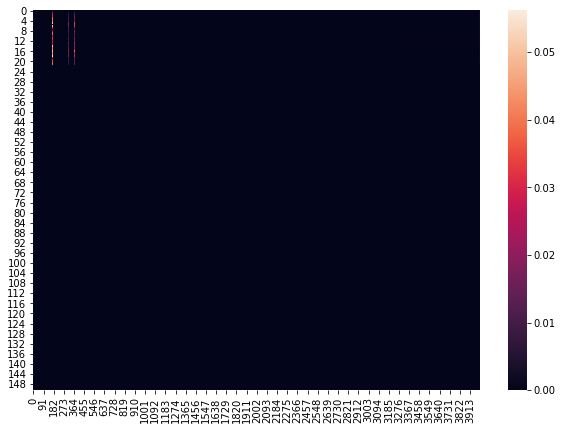

In [67]:
summarise(
    sample_source[3],
    content_compressor,
    summary_generator,
    nested_attention,
    reverse_compression=True,
    greedy_search=True
)